<center>
<h1 style="color:red; font-size:70px;"> Esercitazione 7</h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10

2025-06-29 11:52:22.293977: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 11:52:23.580766: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 11:52:24.274278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751190744.926766    6221 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751190745.071966    6221 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751190746.228760    6221 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

<h1 style="color: blue; font-size:50px;"> Esercizio 1 - CNN classifier</h1>

L'obiettivo di questo esercizio è la costruzione di un semplice ***CNN classifier***, ossia una rete neurale particolarmente efficace per l'elaborazione di dati strutturati in griglie, come per esempio le immagini. Una CNN è caratterizzata da una struttura articolata, dato che solitamente presenta:

- **layer convoluzionali:** applicano dei filtri che scansionano l'immagine e servono ad estrarre caratteristiche locali

- **pooling layer:** riduce la dimensione dell'immagine, mantenendo tuttavia le caratteristiche principali della stessa. Questo processo rende la rete più efficiente e robusta

- **fully connected layers:** prendono come input le caratteristiche estratte nella fase di convoluzione e fanno la classificazione finale

Dimensione training data: (50000, 32, 32, 3)
Dimensione training label: (50000, 1)

Dimensione validation data: (10000, 32, 32, 3)
Dimensione validation label: (10000, 1)


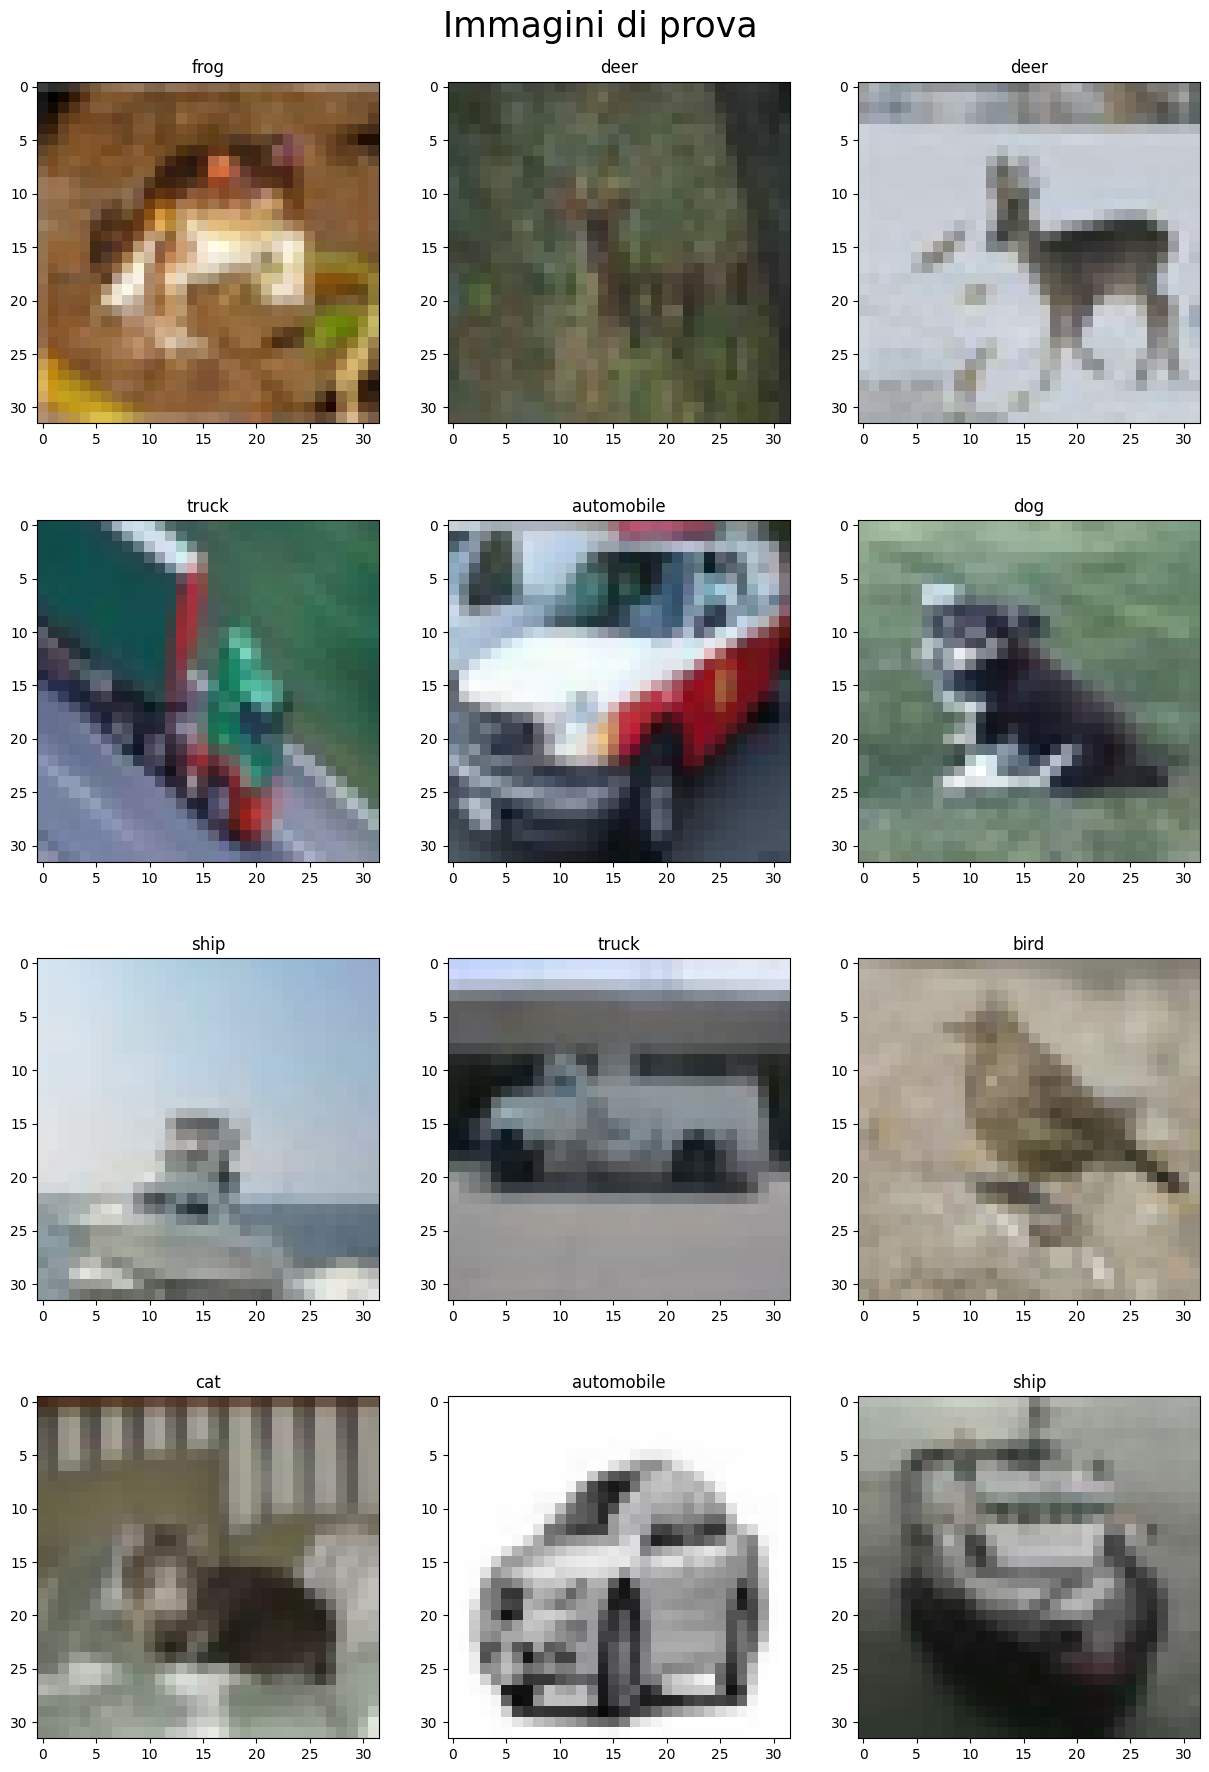

In [13]:
def printImg(imTr, clTr, classes):
    # Funzione per stampare alcune immagini di prova del dataset
    fig, ax = plt.subplots(4, 3, figsize = (15, 20))
    for i in range(0, 4):
        for j in range(0, 3):
            ax[i][j].imshow(imTr[50*i+10*j])
            ax[i][j].set_title(classes[clTr[50*i+10*j, 0]])

    fig.suptitle("Immagini di prova", fontsize = 25)
    plt.subplots_adjust(top=0.95)
    plt.show()


# Ci poniamo di risolvere un problema di classificazione e questo vuol dire che avremo a 
# che fare con delle immagini. In primo luogo dobbiamo caricare il dataset in modo da poterlo
# analizzare. Utilizziamo il dataset cifar, che possiamo direttamente importare da keras. 
# Questo dataset contiene 60mila immagini a bassa definizione contenenti 10 classi di oggetti, ossia
# ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']. Il 
# dataset è diviso in due: 50mila immagini per la fase di allenamento della rete e 10mila immagini per
# quella di validation
(imTr, clTr), (imVal, clVal) = cifar10.load_data()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Studio la dimensione dei  vari dataset scaricati e stampo alcune immaigni di prova
print("Dimensione training data:", imTr.shape)
print("Dimensione training label:", clTr.shape)
print("\nDimensione validation data:", imVal.shape)
print("Dimensione validation label:", clVal.shape)

printImg(imTr, clTr, classes)